# **Projecto Final del WBDS LA Camp**

---
**Maria Isabel Castañeda Fernandez**

El objetivo del projecto fue encontrar operones probables relacionados a la síntesis de antibióticos en *Micromonospora* sp.


# 1. Preparación del entorno

Usé las siguientes bibliotecas para asegurar que todos los programas y códigos que usaremos funcionen correctamente:

- Usaremos [pandas](https://pandas.pydata.org/) para el manejo general de datos
- Usaremos [pyCirclize](https://moshi4.github.io/pyCirclize/) para visualizar nuestros datos genómicos de manera gruesa
- Usaremos [pyrodigal](https://pyrodigal.readthedocs.io/en/stable/) para la predicción de genes codificantes
- Usaremos [requests](https://requests.readthedocs.io/en/latest/) para interactuar con las APIs de NCBI, UniProt e InterProScan
- Usaremos [seaborn](https://seaborn.pydata.org/) para visualizar algunas de manera fina y verificar su ubicación
- Usaremos [subprocess](https://docs.python.org/3/library/subprocess.html) ejecutar comandos fuera del entorno de python
- Usaremos [BioPython](https://biopython.org/) para el manejo de secuencias
- Usaremos [io](https://docs.python.org/3/library/io.html) para conectar las entradas y salidas de los distintos programas

Para instalar las bibliotecas se corrieron los siguientes códigos:

In [ ]:
!pip3 install matplotlib
!pip3 install pandas
!pip3 install pycirclize
!pip3 install pyrodigal
!pip3 install requests
!pip3 install seaborn
!pip3 install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Luego procederemos a importar las librerías necesarias así como las credenciales usando Entrez:

In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
Entrez.email = "maria.castaneda5@unmsm.edu.pe"
Entrez.api_key = "ff65cff33a9f421d4a1549d45eec782de808"
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

# 2. Obtención de nuestra secuencia genómica a trabajar

Usaremos el actinomiceto Micromonospora sp. LH3U1 con el número de acceso CP116936.1. 
Para lo cual descargaremos la secuencia en formato Genbank usando el siguiente código:

In [ ]:
accession = "CP116936.1"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

Verificamos que se haya descargado correctamente la secuencia verificando el tamaño del genoma usando el siguiente comando:

In [ ]:
genome_length

7090248

# 3. Búsqueda de genes codificantes usando Pyrodigal
Se realizó la búsqueda de los ORFs (marco abierto de lectura, relacionado a genes funcionales) mediante Pyrodigal.


In [ ]:
orf_finder = pyrodigal.OrfFinder()
orf_finder.train(bytes(record.seq))
orf_genes  = orf_finder.find_genes(bytes(record.seq))

Las secuencias se encuentran en el objeto "orf_genes", las cuales se guardaron en formato .faa para las secuencias de aminoácidos y el formato .gff que contiene de los genes funcionales.

In [ ]:
aa_file = accession + ".faa"
prefix  = "MicroLH"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

In [ ]:
gff_file = accession + ".gff"
prefix  = "MicroLH"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

# 4. Creación de secuencias de referencia con UNIPROT
Ahora vamos a buscar una base de datos con la cual vamos a realizar el comparativo para la búsqueda de genes relacionados a la síntesis de compuestos antibóticos, en este caso usaremos Uniprot como base de datos de referencia.
Para lo cual obtendremos primero un archivo "uniprot_sequences.fasta" que contiene la lista de secuencias de referencia que estén relacionadas a biosíntesis de antibióticos.

In [ ]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(antibiotic biosynthesis) AND (reviewed:true)"}
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

Creamos el archivo fasta de las secuencias de referencia:

In [ ]:
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

# 5. Comparación de las secuencias de referencia usando BLAST+
Realizamos la comparación de secuencias de referencia tomando también la herramienta de comparación por homología (BLAST) del NCBI.
Para lo cual correremos comando que nos permite instalar el programa.

In [ ]:
!apt-get install ncbi-blast+

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 14.6 MB of archives.
After this operation, 74.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 ncbi-data all 6.1.20170106+dfsg1-8 [3,518 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 ncbi-blast+ amd64 2.9.0-2 [11.1 MB]
Fetched 14.6 MB in 0s (41.7 MB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack .../ncbi-data_6.1.20170106+dfsg1-8_all.deb ...
Unpacking ncbi-data (6.1.20170106+dfsg1-8) ...
Selecting previously unselected package ncbi-blast+.
Preparing to unpack .../ncbi-blast+_2.9.0-2_amd64.deb ...
Unpacking ncbi-bla

Para crear la base de datos con nuestra secuencia en formato de aminoácidos, usaremos el comando:

In [ ]:
makeblastdb_path = "/usr/bin/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']
subprocess.call(makeblastdb_command)

0

Luego generamos el formato de nuestra base de datos. Posteriormente creamos el archivo de salida y el comando para correr la comparación por homología de las secuencias de uniprot contra la base de datos del file de aminoácidos del genoma.

In [ ]:
blastp_path       = "/usr/bin/blastp"
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blastp_out_file   = accession + ".blast.tsv"
blastp_command    = [blastp_path,
                     "-db",          aa_file,
                     "-query",       "uniprot_sequences.fasta",
                     "-evalue",      "1e-9",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "12"]
subprocess.call(blastp_command)

0

O podemos comparar la base de datos las secuencias de referencia de Uniprot de síntesis de antibióticos y lo comparamos con nuestra secuencia:

In [ ]:
makeblastdb_path = "/usr/bin/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',"uniprot_sequences.fasta",'-dbtype','prot']
subprocess.call(makeblastdb_command)
blastp_path      = "/usr/bin/blastp"
blast_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blast_out_file   = "uniprot_sequences.blast.tsv"
blastp_command   = [blastp_path,
                    "-db",          "uniprot_sequences.fasta",
                    "-query",       aa_file,
                    "-evalue",      "1e-9",
                    "-out",         blast_out_file,
                    "-outfmt",      blast_out_format,
                    "-num_threads", "12"]
subprocess.call(blastp_command)

0

# 6. Examinamos los datos obtenidos
Del análisis anterior obtuvimos una tabla de datos llamada "uniprot_sequences.blast.tsv" que se asignó a blastp_out_file.
A esta tabla le daremos formato usando el siguiente código:

In [ ]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)

Verificamos la tabla:

In [ ]:
blastp_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,sp|A0A075TMP8|PATI_PENEN,MicroLH_4550,526,464,118,94,486,443,145,2.110000e-10,379,149
1,sp|A0A075TRC0|PATK_PENEN,MicroLH_2698,1776,2566,35,1162,1011,2111,1139,1.060000e-127,1007,498
2,sp|A0A075TRC0|PATK_PENEN,MicroLH_2698,1776,2566,25,24,455,445,786,8.700000e-85,432,243
3,sp|A0A075TRC0|PATK_PENEN,MicroLH_2696,1776,1815,35,14,1357,1296,1039,5.590000e-116,1366,602
4,sp|A0A075TRC0|PATK_PENEN,MicroLH_2683,1776,592,28,28,529,524,796,1.530000e-92,509,268
...,...,...,...,...,...,...,...,...,...,...,...,...
9585,sp|Q02572|CYPC_STRCN,MicroLH_3477,152,252,3,85,148,230,504,8.600000e-66,146,112
9586,sp|Q02586|CURC_STRCN,MicroLH_3476,154,135,1,1,126,126,383,4.840000e-49,126,93
9587,sp|Q02587|CURD_STRCN,MicroLH_3473,367,106,16,5,109,101,187,4.950000e-18,97,61
9588,sp|Q02588|CURG_STRCN,MicroLH_3481,107,113,1,1,105,104,240,2.590000e-28,105,66


Verificamos los genes candidatos y cuántos son haciendo una lista:

In [ ]:
candidate_genes=blastp_df["sseqid"].unique().tolist()
len(candidate_genes)

831

Transformamos nuestros archivos .gff a un dataframe para evaluar la presencia de operones.

In [ ]:
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)

In [ ]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [ ]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))

Filtramos los datos para que solo se muestre los genes relacionados a síntesis de antibióticos:

In [ ]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

Guardamos los datos en un nuevo dataframe para usarlo en pyCirclize:

In [ ]:
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False)

# 7. Visualización de resultados con pyCirclize
Se realizó la visualización de los operones relacionados a síntesis de antibióticos usando el siguiente comando:

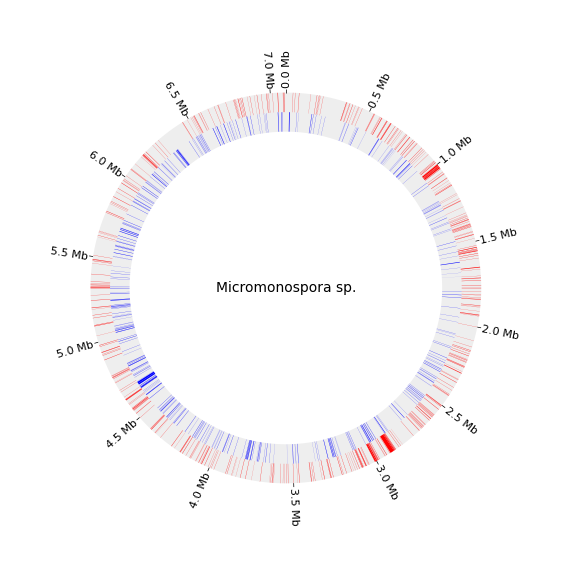

In [ ]:
circos = Circos(sectors={accession: genome_length})
circos.text("Micromonospora sp.")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)

# 8. Visualización de datos de manera fina usando Seaborn
Realizamos una visualización más específica para saber exactamente la posición de la cual extraeremos los genes para evaluar su función usando Seaborn:

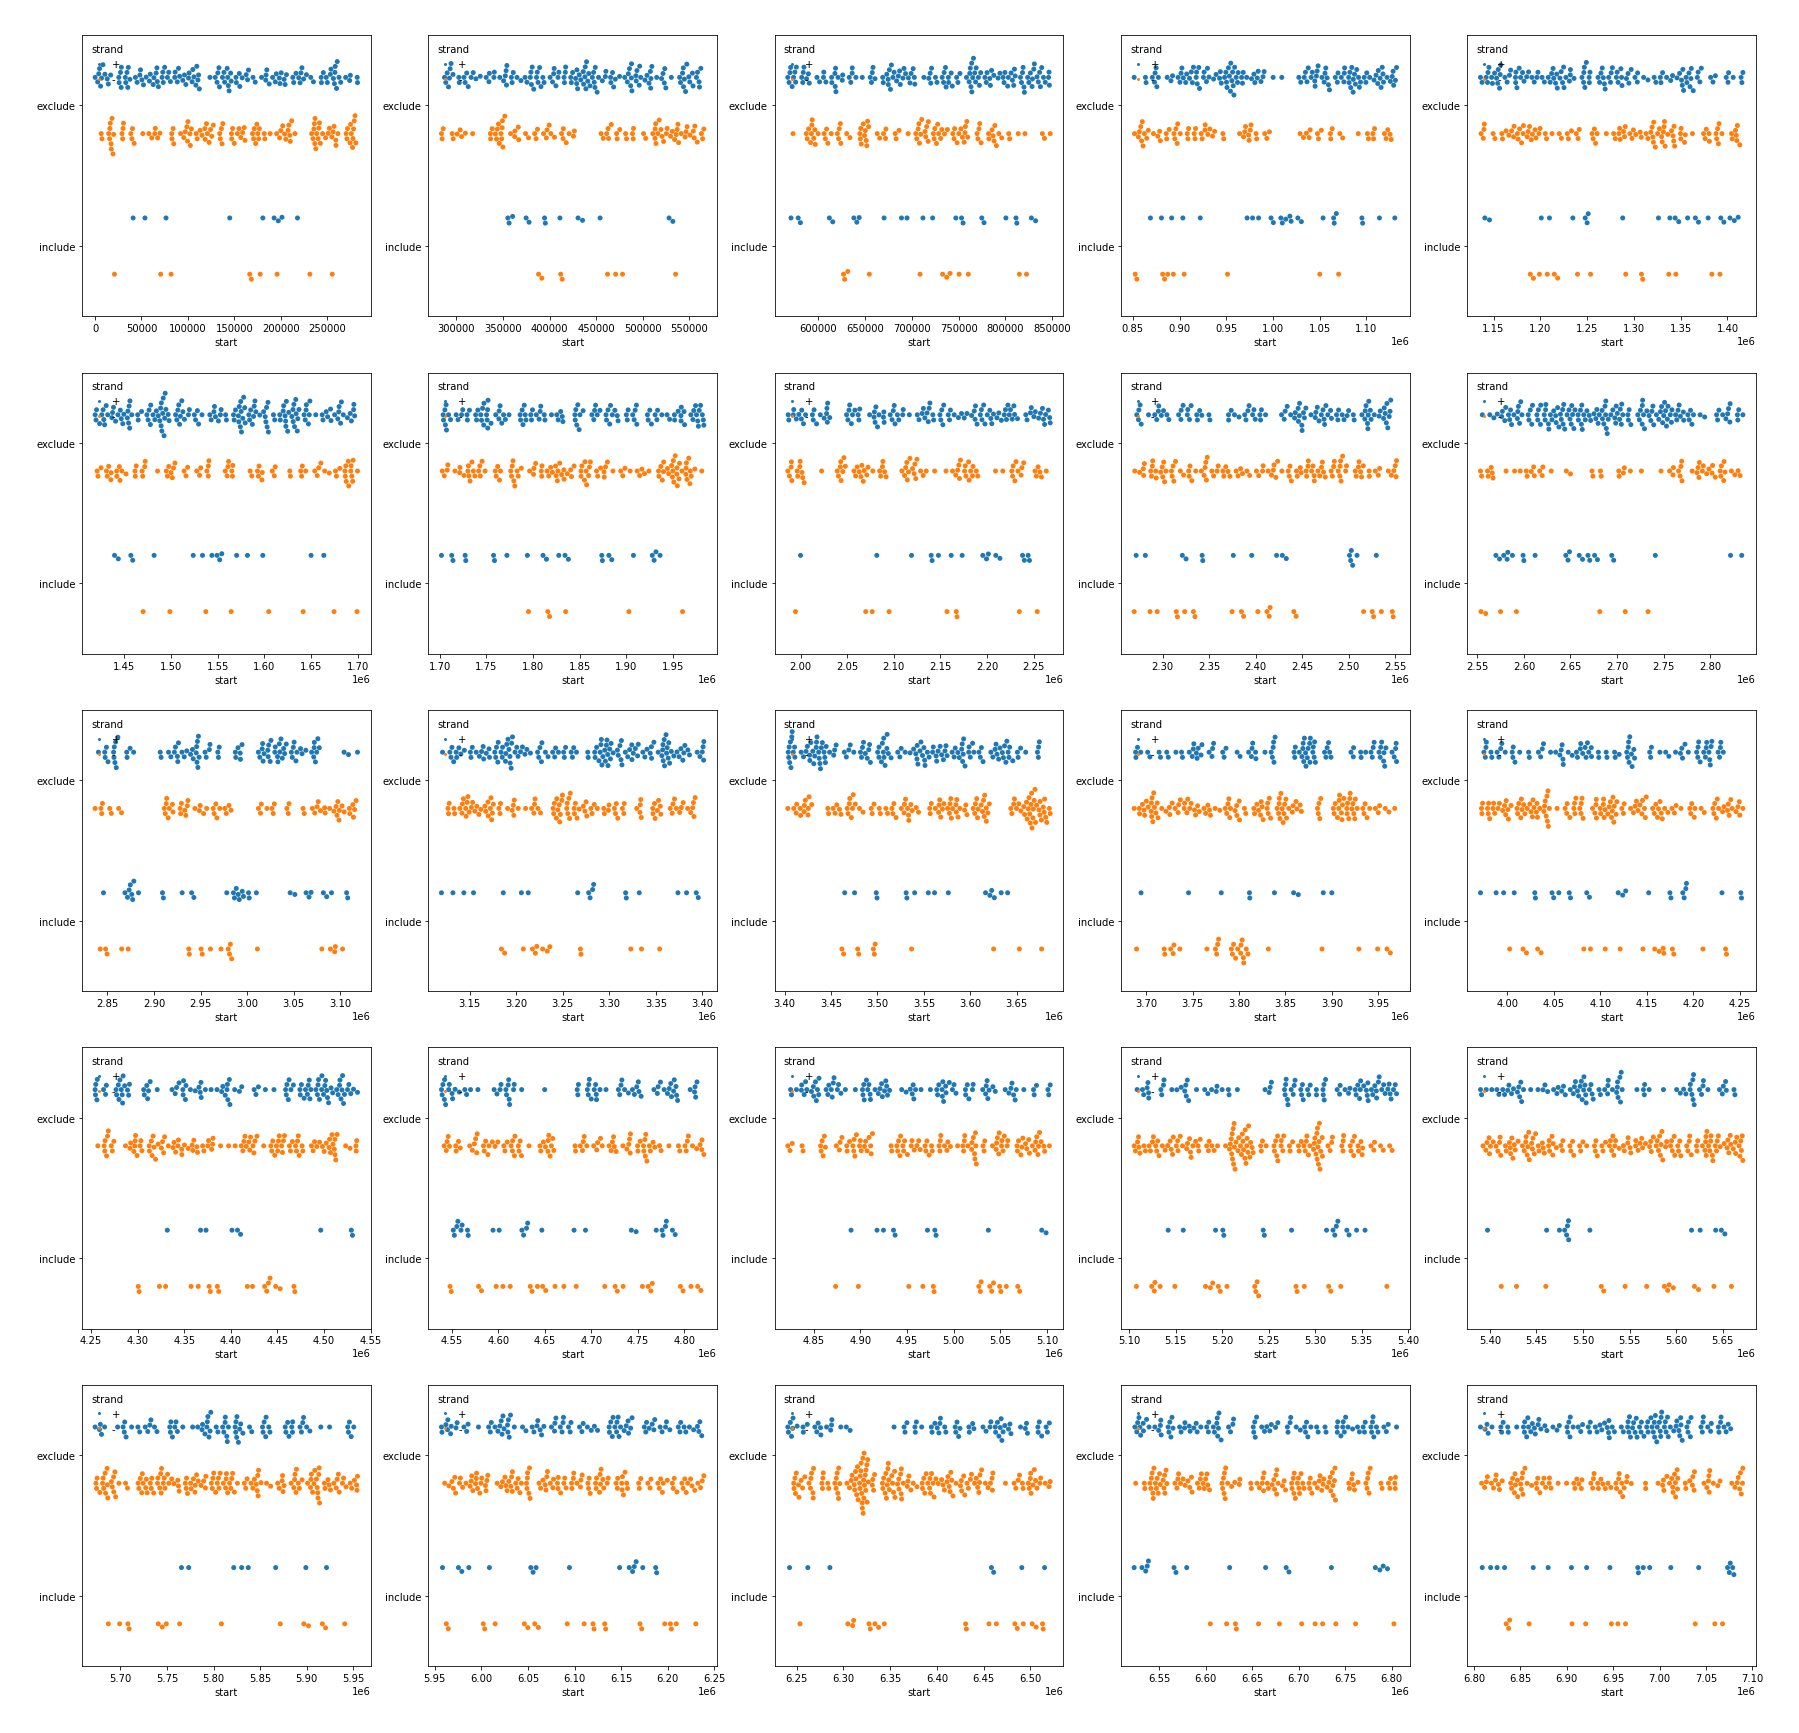

In [ ]:
num_bins = 25
counter_1 = 0
counter_2 = 0
fig, axes = plt.subplots(5,5,figsize=(30,30))
bin_len  = (genome_length - (genome_length % (num_bins - 1))) / (num_bins)
for bin_num in range(num_bins):
    start_pos = bin_num * bin_len
    end_pos   = (bin_num + 1) * bin_len
    mb_df = gff_df.copy()
    mb_df = mb_df[(mb_df["start"]>start_pos) & (mb_df["end"]<=end_pos)]
    sns.swarmplot(ax = axes[counter_1,counter_2],data = mb_df,y="candidate",x="start",hue="strand",dodge=True,order=["exclude","include"],hue_order=["+","-"])
    axes[counter_1,counter_2].set(ylabel=None)
    counter_2 += 1
    if (counter_2%5 == 0):
        counter_2 = 0
        counter_1 += 1
plt.show()

Extraemos las secuencias a un dataframe:

In [ ]:
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 2960000) &
                      (operon_df["end"]       <= 3020000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

Generamos una lista llamada operon_gene_list

In [ ]:
operon_gene_list = []
for index in operon_df.index.tolist():
    gene_id = operon_df["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

Verificamos los ID de la lista de genes:

In [ ]:
operon_gene_list

['MicroLH_2665',
 'MicroLH_2674',
 'MicroLH_2678',
 'MicroLH_2680',
 'MicroLH_2681',
 'MicroLH_2683',
 'MicroLH_2700']

Creamos un string con la lista de aminoácidos en formato fasta usando los IDs:

In [ ]:
query_str = ""

In [ ]:
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

# 9. Análisis de proteínas usando InterPro
Utilizamos Interpro para realizar la clasificación de proteínas de manera funcional, para lo cual brindaremos la locación de Interpro y los parámetros que usaremos:

In [ ]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

In [ ]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

In [ ]:
submit_data = {"email":"maria.castaneda5@unmsm.edu.pe",
               "title":"operon_296_302",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

Subimos la solicitud a Interproscan:

In [ ]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

In [ ]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [ ]:
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230322-021123-0445-16915282-p2m


Verificamos el status de la solicitud usando el comando mostrado abajo, donde el progress_status_code nos indica el código de status, el cual debe ser 200 y el progress_status nos indica el progreso de la solicitud, donde "FINISHED" es que ya se completó la solicitud.

In [ ]:
progress_request     = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


Una vez terminado el análisis con Interpro procedemos a verificar si la solicitud fue realizada de manera norma:

In [ ]:
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [ ]:
print(results_log_request.text)

22/03/2023 02:11:26:248 Welcome to InterProScan-5.61-93.0
22/03/2023 02:11:26:250 Running InterProScan v5 in STANDALONE mode... on Linux
22/03/2023 02:11:32:833 RunID: hx-wp-02-08.ebi.ac.uk_20230322_021132536_acr4
22/03/2023 02:11:46:169 Loading file /nfs/public/rw/es/projects/wp-jdispatcher/logs/prod/sources/jobs/iprscan5/rest/20230322/0210/iprscan5-R20230322-021123-0445-16915282-p2m.sequence
22/03/2023 02:11:46:173 Running the following analyses:
[AntiFam-7.0,CDD-3.20,Coils-2.2.1,FunFam-4.3.0,Gene3D-4.3.0,Hamap-2021_04,MobiDBLite-2.0,PANTHER-17.0,Pfam-35.0,Phobius-1.01,PIRSF-3.10,PIRSR-2021_05,PRINTS-42.0,ProSitePatterns-2022_05,ProSiteProfiles-2022_05,SFLD-4,SignalP_EUK-4.1,SignalP_GRAM_NEGATIVE-4.1,SignalP_GRAM_POSITIVE-4.1,SMART-9.0,SUPERFAMILY-1.75,TIGRFAM-15.0,TMHMM-2.0c]
Available matches will be retrieved from the pre-calculated match lookup service.

Matches for any sequences that are not represented in the lookup service will be calculated locally.
22/03/2023 02:12:06:387 26

Una vez verificado procedemos a generar un dataframe con los resultados y dandole el formato a los encabezados:

In [ ]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)

In [ ]:
results_df

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,MicroLH_2681,e9d3fcc3906369d41cb4ad7f22dc862e,256,Pfam,PF00975,Thioesterase domain,16,239,2.4E-34,T,22-03-2023,IPR001031,Thioesterase
1,MicroLH_2681,e9d3fcc3906369d41cb4ad7f22dc862e,256,Gene3D,G3DSA:3.40.50.1820,alpha/beta hydrolase,2,245,4.1E-55,T,22-03-2023,IPR029058,Alpha/Beta hydrolase fold
2,MicroLH_2681,e9d3fcc3906369d41cb4ad7f22dc862e,256,SUPERFAMILY,SSF53474,alpha/beta-Hydrolases,3,243,1.15E-44,T,22-03-2023,IPR029058,Alpha/Beta hydrolase fold
3,MicroLH_2681,e9d3fcc3906369d41cb4ad7f22dc862e,256,PANTHER,PTHR11487,THIOESTERASE,14,239,7.9E-42,T,22-03-2023,IPR012223,"Thioesterase type II, NRPS/PKS/S-FAS"
4,MicroLH_2665,5194b4eee3861113bfc9955514c81dea,889,PRINTS,PR00364,Disease resistance protein signature,322,336,3.7E-11,T,22-03-2023,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,MicroLH_2700,38c2ffb314dd18ab0b81bc5c5f069372,306,PRINTS,PR00111,Alpha/beta hydrolase fold signature,249,263,3.7E-6,T,22-03-2023,IPR000073,Alpha/beta hydrolase fold-1
86,MicroLH_2700,38c2ffb314dd18ab0b81bc5c5f069372,306,PRINTS,PR00111,Alpha/beta hydrolase fold signature,139,152,3.7E-6,T,22-03-2023,IPR000073,Alpha/beta hydrolase fold-1
87,MicroLH_2700,38c2ffb314dd18ab0b81bc5c5f069372,306,PRINTS,PR00111,Alpha/beta hydrolase fold signature,125,138,3.7E-6,T,22-03-2023,IPR000073,Alpha/beta hydrolase fold-1
88,MicroLH_2700,38c2ffb314dd18ab0b81bc5c5f069372,306,SUPERFAMILY,SSF53474,alpha/beta-Hydrolases,22,287,1.91E-55,T,22-03-2023,IPR029058,Alpha/Beta hydrolase fold


Verificamos cuántos de estos genes son únicos, es decir no se encuentran repetidos:

In [64]:
operon_extracted_annotation=results_df["name"].unique().tolist()
len(operon_extracted_annotation)

34

In [65]:
operon_extracted_annotation

['Thioesterase',
 'Alpha/Beta hydrolase fold',
 'Thioesterase type II, NRPS/PKS/S-FAS',
 '-',
 'Tetratricopeptide-like helical domain superfamily',
 'NB-ARC',
 'P-loop containing nucleoside triphosphate hydrolase',
 'Amino acid adenylation domain',
 'Trimeric LpxA-like superfamily',
 'AMP-binding enzyme, C-terminal domain superfamily',
 'AMP-dependent synthetase/ligase domain',
 'ANL, N-terminal domain',
 'Non-ribosomal peptide synthetase, C-terminal',
 'Phosphopantetheine binding ACP domain',
 'ACP-like superfamily',
 'AMP-binding, conserved site',
 'Hexapeptide transferase, conserved site',
 'Polyketide synthase, phosphopantetheine-binding domain',
 'Transcription regulator LuxR, C-terminal',
 'Signal transduction response regulator, C-terminal effector',
 'CheY-like superfamily',
 'Signal transduction response regulator, receiver domain',
 'Transcriptional regulatory protein WalR-like',
 'Bacterial transcriptional activator domain',
 'Winged helix-like DNA-binding domain superfamily